# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

python -m venv .venv
.venv\Scripts\activate
pip install jupyter numpy matplotlib
pip install torch torchvision torchaudio
pip install jax jaxlib
```



In [17]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax

# In order to learn JAX I will attempt this same problem using the python library JAX

In [2]:

# Function to turn images into gifs.


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

"""
def oscillator(d, w0, x):
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y
"""
# Using Jax
def oscillator(d, w0, t):
    """
    Analytical solution to 1D underdamped harmonic oscillator.
    
    Solves: d²x/dt² + 2δ(dx/dt) + ω₀²x = 0
    
    IMPORTANT - FIXED INITIAL CONDITIONS:
        x(0) = 1.0      (initial position)
        v(0) = 0.0      (initial velocity)
    
    Args:
        d: Damping coefficient δ
        w0: Natural frequency ω₀
        t: Time values
        
    Returns:
        x(t): Position at time t
        
    Note: For different initial conditions, A and φ must be recalculated!
    """
     
    assert d < w0
    w = jnp.sqrt(w0**2-d**2)

    phi = jnp.arctan(-d/w)

    A = 1/(2*jnp.cos(phi))

    cos_term = jnp.cos(phi + w*t)
    exp_term = jnp.exp(-d*t)
    y = exp_term * 2*A* cos_term

    return y


In [3]:
# Neural Network using Jax

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., [1, 32, 32, 32, 1]
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x

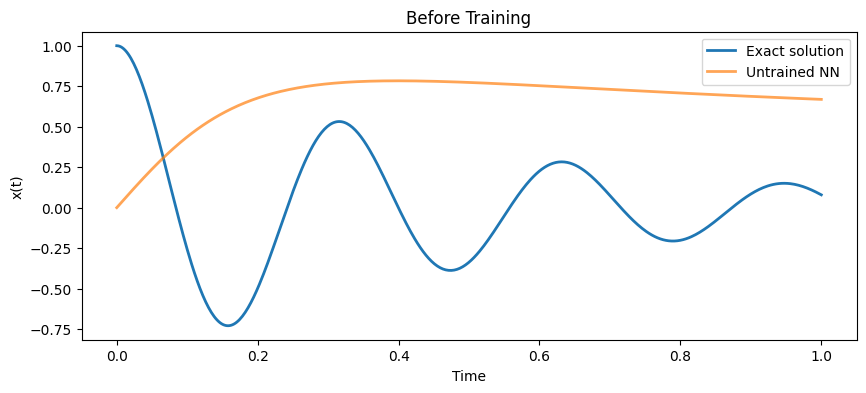

Exact solution shape: (500, 1)
NN prediction shape: (500, 1)


In [5]:
#Test
# Generate data
t = jnp.linspace(0, 1, 500).reshape(-1, 1)  # Shape (500, 1)
y_exact = oscillator(2.0, 20.0, t.squeeze()).reshape(-1, 1)

# Initialize network
key = random.PRNGKey(0) # Like setting a seed
layer_sizes = [1, 32, 32, 32, 1]  # 3 hidden layers with 32 neurons
params = init_network_params(layer_sizes, key)

# Get prediction (before training - will be random!)
y_nn = network(params, t)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t, y_exact, label='Exact solution', linewidth=2)
plt.plot(t, y_nn, label='Untrained NN', linewidth=2, alpha=0.7)
plt.legend()
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Before Training')
plt.show()

print(f"Exact solution shape: {y_exact.shape}")
print(f"NN prediction shape: {y_nn.shape}")

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

(500, 1) (500, 1)
(10, 1) (10, 1)


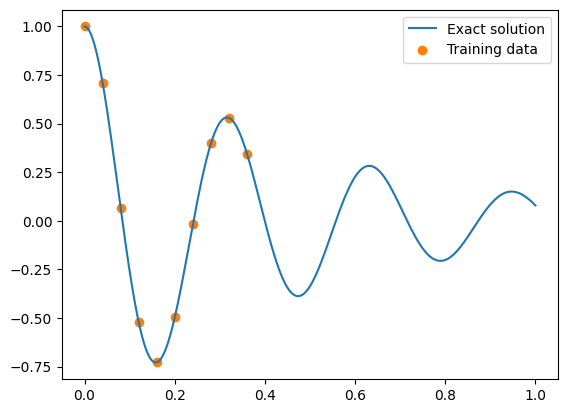

In [6]:
d, w0 = 2, 20

# get the analytical solution over the full domain
# linspace(0,1,500) creates 500 evenly-spaced numbers from 0 to 1
# reshape(-1, 1) changes from 1D vector to 2D column vector. '-1' means figure out this dimension automatically. '1' means make second dimension size 1.
x = jnp.linspace(0,1,500).reshape(-1,1)
y = oscillator(d, w0, x).reshape(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

Step 0, Loss: 0.311047
Step 100, Loss: 0.123949
Step 200, Loss: 0.033151
Step 300, Loss: 0.022753
Step 400, Loss: 0.013405


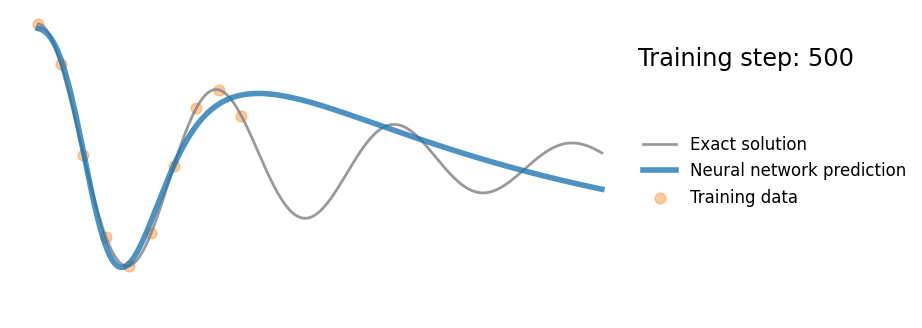

Step 500, Loss: 0.006436
Step 600, Loss: 0.002309
Step 700, Loss: 0.000684
Step 800, Loss: 0.000328
Step 900, Loss: 0.000228


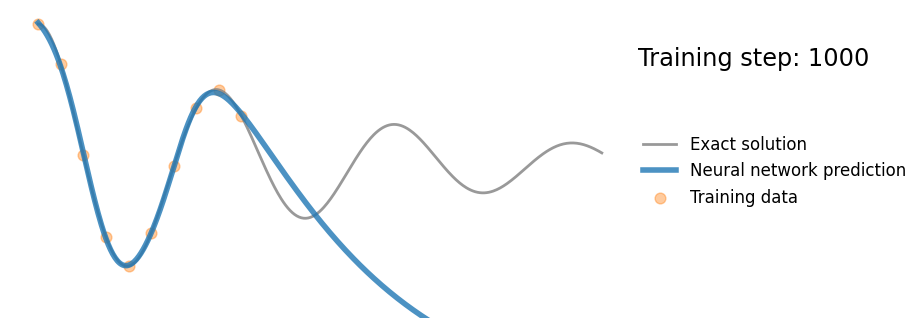

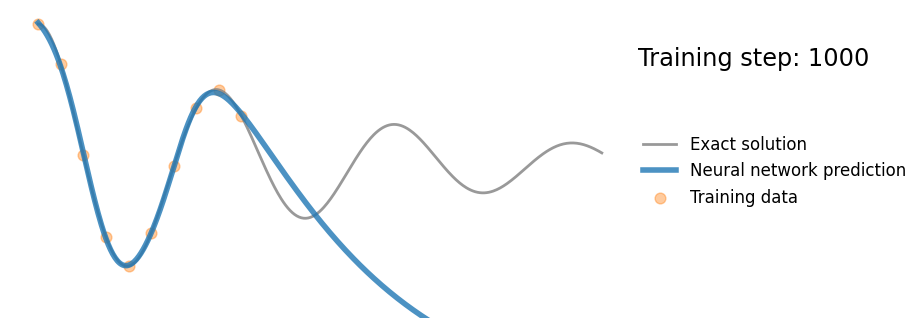

In [8]:
# ==== Fixed plot function (removed PyTorch dependency) =====
def plot_result(x, y, x_data, y_data, yh, i, xp=None):
    """Pretty plot training results"""
    plt.figure(figsize=(8,4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x, yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    
    if xp is not None:
        # Changed from torch.ones_like to np.ones_like
        plt.scatter(xp, -0*np.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, f"Training step: {i+1}", fontsize="xx-large", color="k")
    plt.axis("off")
    
key = random.PRNGKey(0)
params = init_network_params([1, 32, 32, 1], key)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

# Loss function
def loss_fn(params, x, y):
    # Normal NN only mean square error loss
    y_pred = network(params, x)
    return jnp.mean((y_pred - y)**2)

# Training loop
for i in range(1000):
    # Compute gradients
    loss_val, grads = jax.value_and_grad(loss_fn)(params, x_data, y_data)
    
    # Update parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss_val:.6f}")

    # ===== ADD PLOTTING HERE =====
    if (i+1) % 10 == 0:  # Plot every 10 steps
        # Get prediction on full domain
        yh = network(params, x)
        
        # Convert JAX arrays to numpy and flatten for plotting
        x_plot = np.array(x).ravel()      # Shape: (500,) 
        y_plot = np.array(y).ravel()      # Shape: (500,)
        x_data_plot = np.array(x_data).ravel()  # Shape: (10,)
        y_data_plot = np.array(y_data).ravel()  # Shape: (10,)
        yh_plot = np.array(yh).ravel()    # Shape: (500,)
        
        # Plot
        plot_result(x_plot, y_plot, x_data_plot, y_data_plot, yh_plot, i)
        
        # Show every 500 steps, otherwise close
        if (i+1) % 500 == 0:
            plt.show()
        else:
            plt.close("all")


yh_final = network(params, x)
plot_result(np.array(x).ravel(), np.array(y).ravel(), 
            np.array(x_data).ravel(), np.array(y_data).ravel(), 
            np.array(yh_final).ravel(), 999)
plt.show()

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

Data: 10, Physics: 30
Training (first iteration will compile - takes ~2 seconds)...

Step 1000: Loss=0.248755, Time=0.0010s
Step 2000: Loss=0.199137, Time=0.0000s
Step 3000: Loss=0.158630, Time=0.0000s
Step 4000: Loss=0.107864, Time=0.0000s
Step 5000: Loss=0.085389, Time=0.0000s
Step 6000: Loss=0.067049, Time=0.0000s


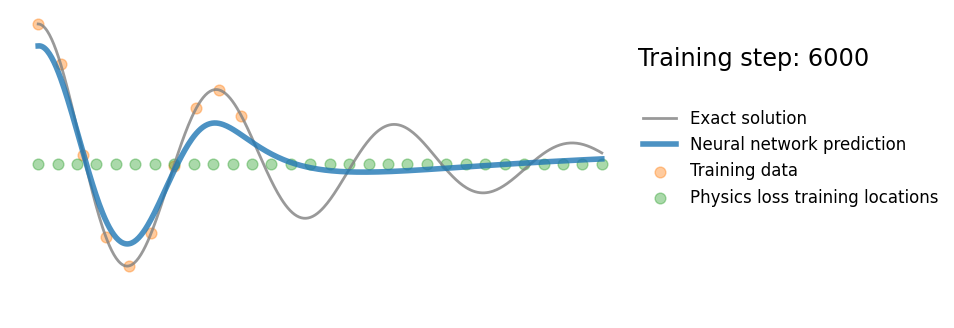

Step 7000: Loss=0.047703, Time=0.0000s
Step 8000: Loss=0.031356, Time=0.0000s
Step 9000: Loss=0.021623, Time=0.0000s
Step 10000: Loss=0.010167, Time=0.0000s
Step 11000: Loss=0.008134, Time=0.0008s
Step 12000: Loss=0.005905, Time=0.0000s


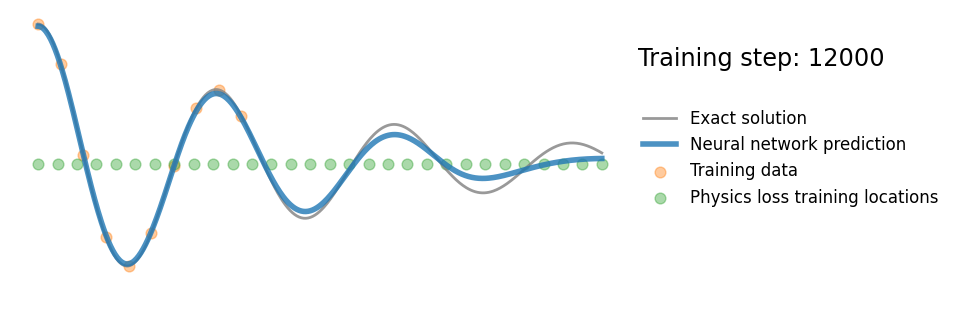

Step 13000: Loss=0.001796, Time=0.0000s
Step 14000: Loss=0.000464, Time=0.0000s
Step 15000: Loss=0.000237, Time=0.0014s
Step 16000: Loss=0.000175, Time=0.0011s
Step 17000: Loss=0.000137, Time=0.0000s
Step 18000: Loss=0.000107, Time=0.0007s


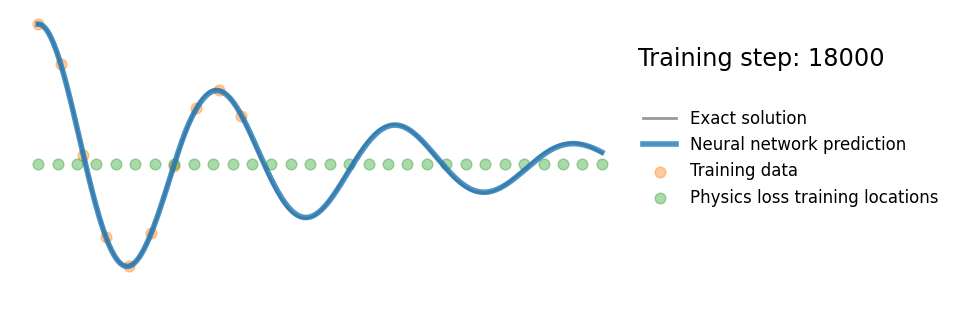

Step 19000: Loss=0.000081, Time=0.0014s
Step 20000: Loss=0.000062, Time=0.0006s

Complete!
Took:  28.757463693618774


In [13]:
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit  # <-- Import jit
import optax
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# ===== [Your existing functions: network, oscillator, etc.] =====

total_start = time.time()

# ===== Physics residual (same as before) =====
def physics_residual_single(params, t_point, mu, k):
    def u(t_val):
        t_in = jnp.array([[t_val]])
        return network(params, t_in)[0, 0]
    
    du_dt = grad(u)(t_point)
    d2u_dt2 = grad(grad(u))(t_point)
    u_val = u(t_point)
    
    return d2u_dt2 + mu * du_dt + k * u_val

physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, None, None))


# ===== THE KEY: JIT-compiled update function =====
@jit  # <-- THIS ONE LINE MAKES IT FAST!
def update_step(params, opt_state, x_data, y_data, x_physics_flat, mu, k):
    """
    Single training step - JIT compiled!
    """
    def loss_fn(p):
        # Data loss
        yh = network(p, x_data)
        data_loss = jnp.mean((yh - y_data)**2)
        
        # Physics loss
        phys_res = physics_residual_batch(p, x_physics_flat, mu, k)
        phys_loss = (1e-4) * jnp.mean(phys_res**2)
        
        return data_loss + phys_loss
    
    # Compute loss and gradients
    total_loss = loss_fn(params)
    grads = grad(loss_fn)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, total_loss


# ===== Setup (same as before) =====
d, w0 = 2.0, 20.0
x = jnp.linspace(0, 1, 500).reshape(-1, 1)
y = oscillator(d, w0, x.ravel()).reshape(-1, 1)
x_data = x[0:200:20]
y_data = y[0:200:20]
x_physics = jnp.linspace(0, 1, 30).reshape(-1, 1)
x_physics_flat = x_physics.ravel()
mu, k = 2*d, w0**2

# Initialize
key = random.PRNGKey(123)
params = init_network_params([1, 32, 32, 32, 1], key)
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)

files = []

print(f"Data: {x_data.shape[0]}, Physics: {x_physics.shape[0]}")
print("Training (first iteration will compile - takes ~2 seconds)...\n")


# ===== Training loop (FAST!) =====
import time

for i in range(20000):
    
    start = time.time()
    
    # This is now FAST (compiled!)
    params, opt_state, total_loss = update_step(
        params, opt_state, x_data, y_data, x_physics_flat, mu, k
    )
    
    elapsed = time.time() - start
    
    # Monitor
    if (i+1) % 1000 == 0:
        print(f"Step {i+1}: Loss={total_loss:.6f}, Time={elapsed:.4f}s")
    
    # Plot (do this OUTSIDE the JIT function)
    if (i+1) % 150 == 0:
        yh_plot = network(params, x)  # This is fast even without JIT
        
        plot_result(np.array(x).ravel(), np.array(y).ravel(),
                    np.array(x_data).ravel(), np.array(y_data).ravel(),
                    np.array(yh_plot).ravel(), i, np.array(x_physics).ravel())
        
        file = "figures/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0:
            plt.show()
        else:
            plt.close()

save_gif_PIL("pinn.gif", files, fps=20, loop=0)

print("\nComplete!")
print("Took: ", time.time() - total_start)